### 온열질환자 구간에 따른 Classification 모델 생성
- 1-dimensional
    : binning
- 2-dimensional
    : clustering

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

# pd.set_option('display.max_rows', None)
# pd.set_option('display.max_columns', None)
import os
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, Normalizer, LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

In [2]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from keras.models import Sequential
from keras.layers import SimpleRNN, LSTM, Dense

In [3]:
# 나눔 폰트 경로 설정
# dir = '/data1/E382/hwchoi/00.data/00.preprocessing'
dir='C:/Windows/Fonts'
font_path = os.path.join(dir, 'NANUMGOTHIC.TTF')
# font_path = os.path.join(dir, 'DejaVu Sans')

# 폰트 속성 설정
fontprop = fm.FontProperties(fname=font_path, size=10)


# 폰트 매니저에 폰트 추가
fm.fontManager.addfont(font_path)

# Matplotlib 폰트 캐시 파일 삭제 (필요시 사용)
cache_dir = os.path.expanduser('~/.cache/matplotlib')
font_cache_path = os.path.join(cache_dir, 'fontlist-v330.json')
if os.path.exists(font_cache_path):
    os.remove(font_cache_path)

# 폰트를 matplotlib에 설정
plt.rc('font', family=fontprop.get_name())

###  MODELING

### SVM, DecisionTree, RandomForest, XGBoost 데이터 셋 재정리

### Binning

In [4]:
path='D:/Work/002.code/jupyterNotebook/data/HEAT_TARGET/T_PATIENTS_DAILY_WHOLE_CLUSTERING_0808.csv'
df=pd.read_csv(path)
df.head(2)

,create_date,sido_cd,sido,weekend_yn,grid_x,grid_y,sat_x,sat_y,min_ta,max_ta,...,ta_min_six_pm2,ta_max_six_pm2,ta_mean_six_pm2,patientsCnt,auto_binning,max_ta_cluster,max_wbtemp_cluster,max_tafeel_cluster,instDate,updtDate
0,2014-05-01,31,경기도,0,60,120,NaN,NaN,9.6,24.2,...,14,21,17,0,0,0,0,0,2024-07-31,2024-07-31
1,2014-05-01,33,충청북도,0,69,107,NaN,NaN,10.5,23.7,...,15,22,18,0,0,0,0,0,2024-07-31,2024-07-31


In [5]:
# patientsCnt를 숫자로 변환
df['patientsCnt'] = df['patientsCnt'].astype(int)

counts, bin_edges = np.histogram(df[df['patientsCnt']!='0']['patientsCnt'], bins=20)

print("Bin edges: ", bin_edges)
print("Counts in each bin: ", counts)

Bin edges:  [ 0.   3.9  7.8 11.7 15.6 19.5 23.4 27.3 31.2 35.1 39.  42.9 46.8 50.7
 54.6 58.5 62.4 66.3 70.2 74.1 78. ]
Counts in each bin:  [24515   997   288   107    44    22    16     8     4     0     1     0
     1     3     0     2     0     0     1     1]


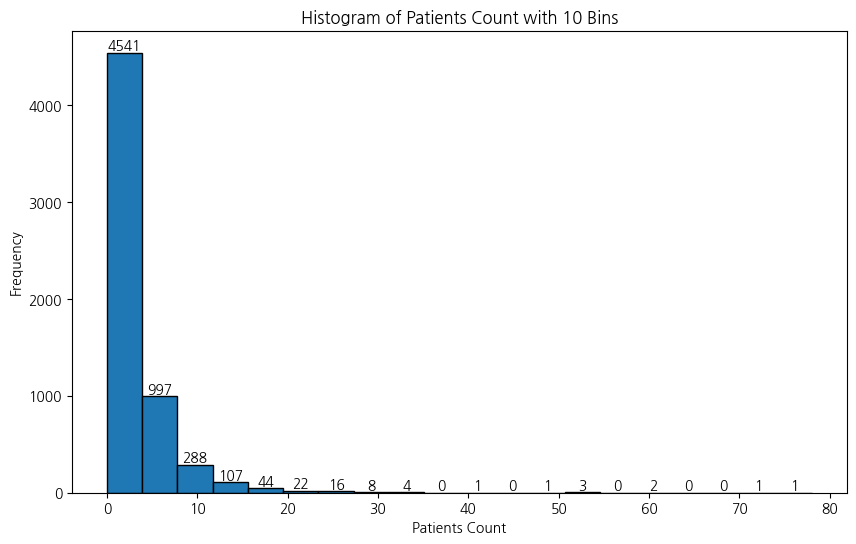

In [6]:
# 시각화
plt.figure(figsize=(10, 6))
n, bins, patches = plt.hist(df[df['patientsCnt'] != 0]['patientsCnt'], bins=bin_edges, edgecolor='black')

# 각 bin의 개수를 히스토그램 위에 표시
for i in range(len(patches)):
    plt.text(patches[i].get_x() + patches[i].get_width() / 2, n[i], str(int(n[i])), ha='center', va='bottom')

# 히스토그램 출력
plt.title('Histogram of Patients Count with 10 Bins')
plt.xlabel('Patients Count')
plt.ylabel('Frequency')
plt.show()

### Binning / 20구간 Modeling

In [7]:
# 조건과 조건에 따른 값을 지정
conditions = [
    (df['patientsCnt'] >= 1) & (df['patientsCnt'] < 4),
    (df['patientsCnt'] >= 4) & (df['patientsCnt'] < 12),
    (df['patientsCnt'] >= 12)
]

# 각 조건에 해당하는 값
values = [1, 2, 3]

In [8]:
df['binning_20'] = np.select(conditions, values, default=0)

In [9]:
df.groupby('binning_20').size()

binning_20
0    19974
1     4541
2     1285
3      210
dtype: int64

In [10]:
# create_date에 대한 sorting 적용
df['create_date'] = pd.to_datetime(df['create_date'])
df.sort_values(by='create_date', inplace=True)
# 결측치 채우기
df = df.fillna(0)

In [11]:
features=['weekend_yn', 'min_ta', 'max_ta', 'mean_ta', 'gap_ta', 'min_tafeel', 'max_tafeel', 'mean_tafeel', 'gap_tafeel', 'min_hm', 'max_hm', 'mean_hm', 'gap_hm', 'min_wbtemp', 'max_wbtemp', 'mean_wbtemp', 'gap_wbtemp', 'min_ws', 'max_ws', 'mean_ws', 'tropical_3days',
       'heatwave_temp', 'heatalert_temp', 'ta_min_3days', 'ta_max_3days', 'gap_ta_minmax', 'popular_man', 'popular_woman', 'agriculture_man', 'agriculture_woman', 'ta_min_am', 'ta_max_am', 'ta_mean_am', 'ta_min_pm', 'ta_max_pm', 'ta_mean_pm', 'ta_min_six_am1',
       'ta_max_six_am1', 'ta_mean_six_am1', 'ta_min_six_am2', 'ta_max_six_am2', 'ta_mean_six_am2', 'ta_min_six_pm1', 'ta_max_six_pm1', 'ta_mean_six_pm1', 'ta_min_six_pm2', 'ta_max_six_pm2', 'ta_mean_six_pm2']
target='binning_20'
print(len(features))

48


In [12]:
# 기본 모델(RandomForest, XGBoost)
# 학습 데이터와 테스트 데이터로 분할
# 데이터 스케일링
X_train, X_test, y_train, y_test = train_test_split(df[features], df[target], test_size=0.2, random_state=15, shuffle=True)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Label Encoding for y
# le = LabelEncoder()
# y_train = le.fit_transform(y_train)
# y_test = le.transform(y_test)

In [13]:
def plot_confusion_matrix(conf_matrix, model_name, accuracy):
    plt.figure(figsize=(10, 7))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{model_name} Confusion Matrix\nAccuracy: {accuracy:.2f}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

In [14]:
performance_list = []
num_classes = 4

def evaluate_model(model, model_name):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True, zero_division=1)
    confusion = confusion_matrix(y_test, y_pred)
    
    for cls in range(num_classes):
        cls = str(cls)
        performance_list.append({
            'Model': model_name,
            'Class': cls,
            'Accuracy': accuracy,
            'Precision': report[cls]['precision'],
            'Recall': report[cls]['recall'],
            'F1-Score': report[cls]['f1-score'],
            'Support': report[cls]['support']
        })
    
    plot_confusion_matrix(confusion, model_name, accuracy)

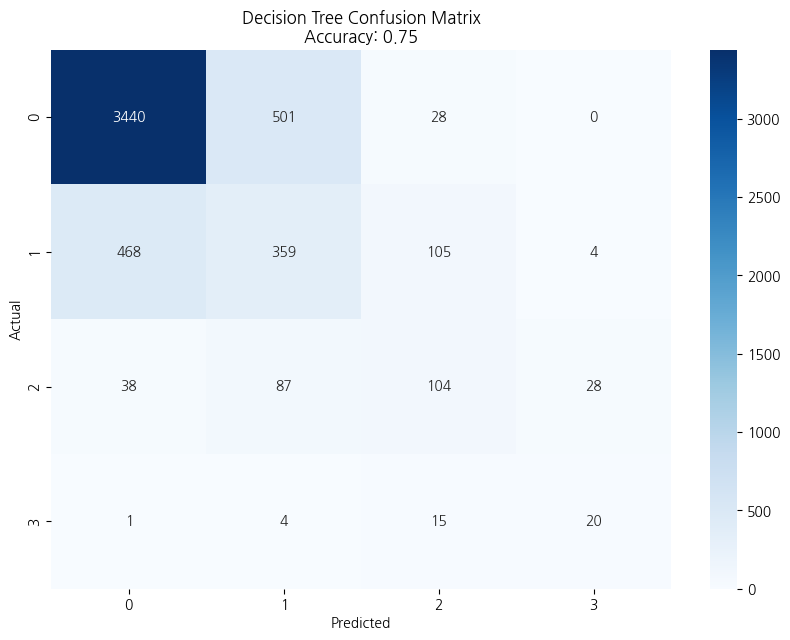

In [15]:
# Decision Tree
dt_classifier = DecisionTreeClassifier(random_state=15)
evaluate_model(dt_classifier, 'Decision Tree')

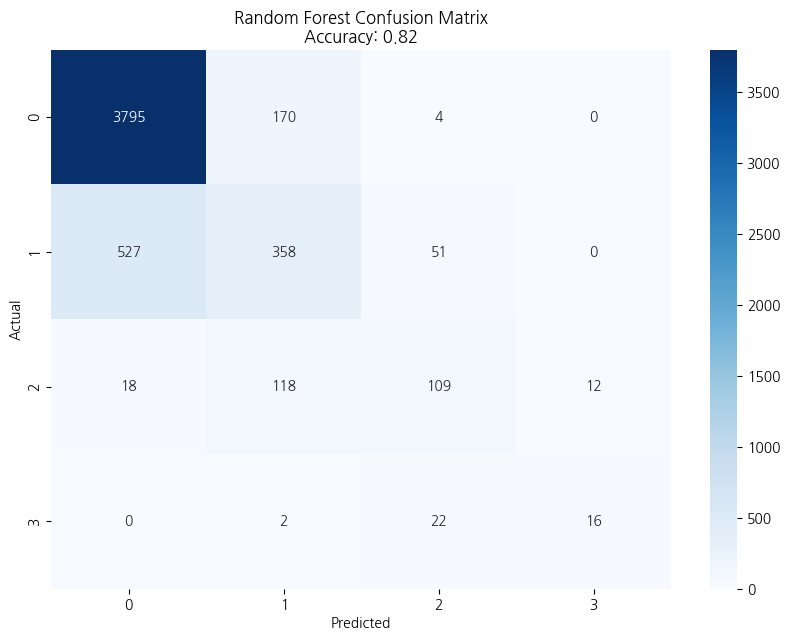

In [16]:
# Random Forest
rf_classifier = RandomForestClassifier(n_estimators=60, random_state=15)
evaluate_model(rf_classifier, 'Random Forest')

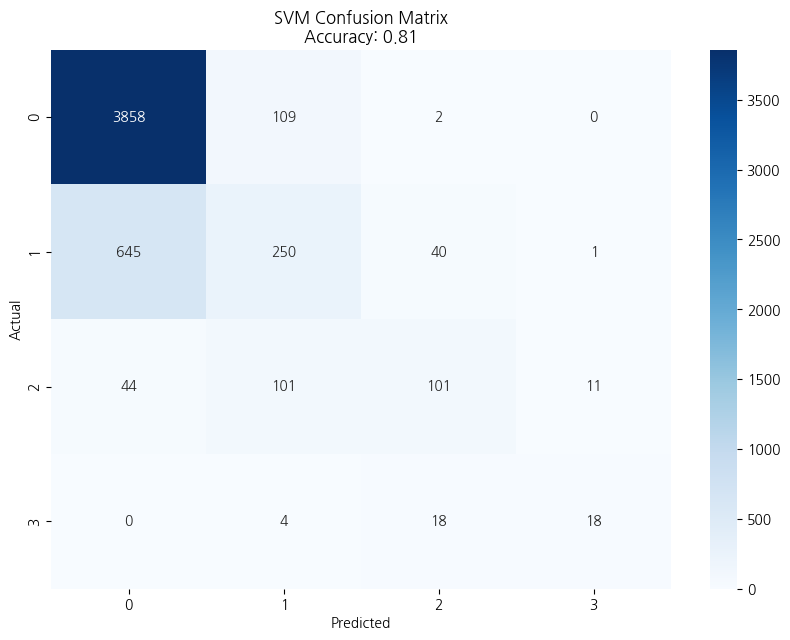

In [17]:
# SVM
svm_classifier = SVC(kernel='linear', random_state=15)
evaluate_model(svm_classifier, 'SVM')

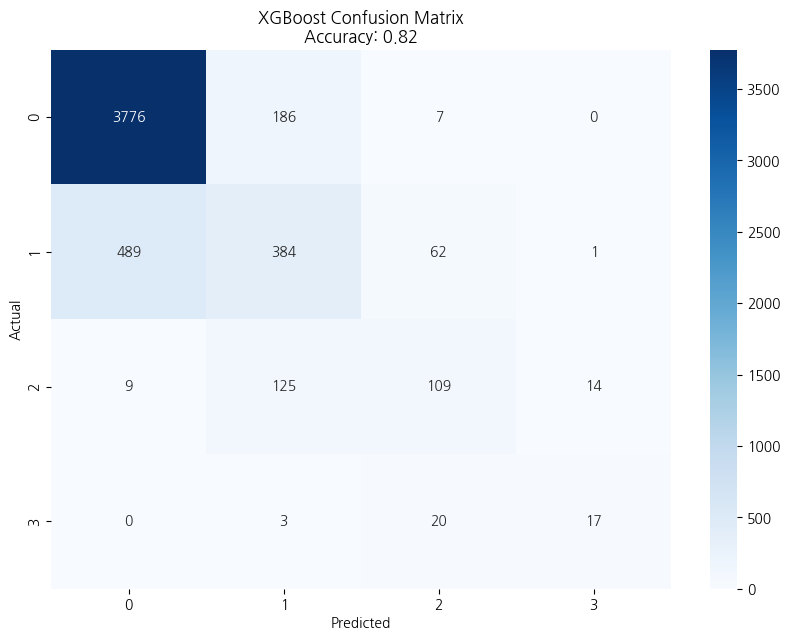

In [18]:
# XGBoost
xgb_classifier = XGBClassifier(eval_metric='logloss', random_state=15)
evaluate_model(xgb_classifier, 'XGBoost')

In [19]:
# 성능 데이터프레임 생성
performance_20 = pd.DataFrame(performance_list)
print(performance_20)
performance_20.to_csv('binning_20_hist.csv', index=False, encoding='utf-8-sig')

            Model Class  Accuracy  Precision    Recall  F1-Score  Support
0   Decision Tree     0  0.754133   0.871548  0.866717  0.869126   3969.0
1   Decision Tree     1  0.754133   0.377497  0.383547  0.380498    936.0
2   Decision Tree     2  0.754133   0.412698  0.404669  0.408644    257.0
3   Decision Tree     3  0.754133   0.384615  0.500000  0.434783     40.0
4   Random Forest     0  0.822376   0.874424  0.956160  0.913467   3969.0
5   Random Forest     1  0.822376   0.552469  0.382479  0.452020    936.0
6   Random Forest     2  0.822376   0.586022  0.424125  0.492099    257.0
7   Random Forest     3  0.822376   0.571429  0.400000  0.470588     40.0
8             SVM     0  0.812572   0.848472  0.972033  0.906059   3969.0
9             SVM     1  0.812572   0.538793  0.267094  0.357143    936.0
10            SVM     2  0.812572   0.627329  0.392996  0.483254    257.0
11            SVM     3  0.812572   0.600000  0.450000  0.514286     40.0
12        XGBoost     0  0.823914   0.

### Binning / 15구간 Modeling

In [20]:
# path='D:/Work/002.code/jupyterNotebook/data/HEAT_TARGET/T_PATIENTS_DAILY_WHOLE_CLUSTERING_0808.csv'
# df=pd.read_csv(path)
# df.head(2)

In [21]:
performance_list = []
num_classes = 4
# 조건과 조건에 따른 값을 지정
conditions = [
    (df['patientsCnt'] >= 1) & (df['patientsCnt'] < 6),
    (df['patientsCnt'] >= 6) & (df['patientsCnt'] < 11),
    (df['patientsCnt'] >= 11)
]

# 각 조건에 해당하는 값
values = [1, 2, 3]

df['binning_15'] = np.select(conditions, values, default=0)

In [22]:
# create_date에 대한 sorting 적용
df['create_date'] = pd.to_datetime(df['create_date'])
df.sort_values(by='create_date', inplace=True)
# 결측치 채우기
df = df.fillna(0)

features=['weekend_yn', 'min_ta', 'max_ta', 'mean_ta', 'gap_ta', 'min_tafeel', 'max_tafeel', 'mean_tafeel', 'gap_tafeel', 'min_hm', 'max_hm', 'mean_hm', 'gap_hm', 'min_wbtemp', 'max_wbtemp', 'mean_wbtemp', 'gap_wbtemp', 'min_ws', 'max_ws', 'mean_ws', 'tropical_3days',
       'heatwave_temp', 'heatalert_temp', 'ta_min_3days', 'ta_max_3days', 'gap_ta_minmax', 'popular_man', 'popular_woman', 'agriculture_man', 'agriculture_woman', 'ta_min_am', 'ta_max_am', 'ta_mean_am', 'ta_min_pm', 'ta_max_pm', 'ta_mean_pm', 'ta_min_six_am1',
       'ta_max_six_am1', 'ta_mean_six_am1', 'ta_min_six_am2', 'ta_max_six_am2', 'ta_mean_six_am2', 'ta_min_six_pm1', 'ta_max_six_pm1', 'ta_mean_six_pm1', 'ta_min_six_pm2', 'ta_max_six_pm2', 'ta_mean_six_pm2']
target='binning_15'
print(len(features))

48


In [23]:
# 기본 모델(RandomForest, XGBoost)
# 학습 데이터와 테스트 데이터로 분할
# 데이터 스케일링
X_train, X_test, y_train, y_test = train_test_split(df[features], df[target], test_size=0.2, random_state=15, shuffle=True)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


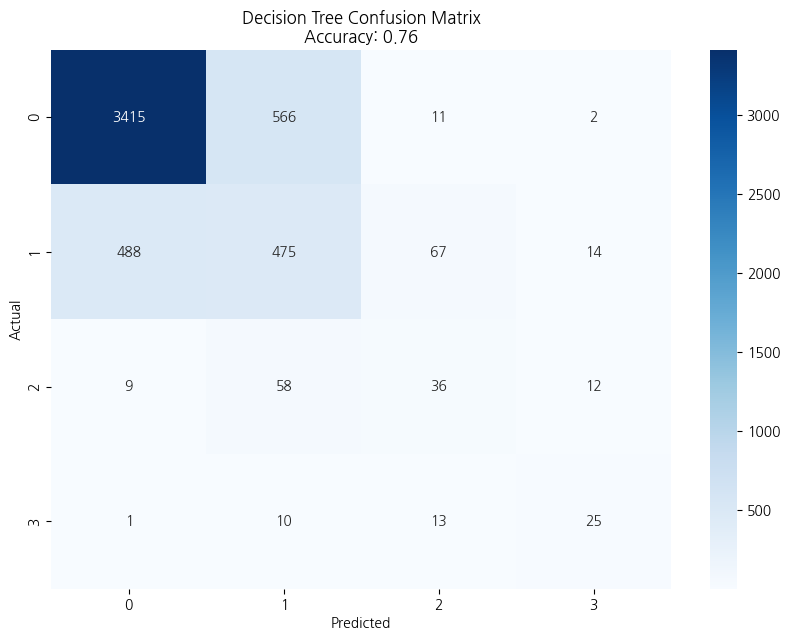

In [24]:
# Decision Tree
dt_classifier = DecisionTreeClassifier(random_state=15)
evaluate_model(dt_classifier, 'Decision Tree')

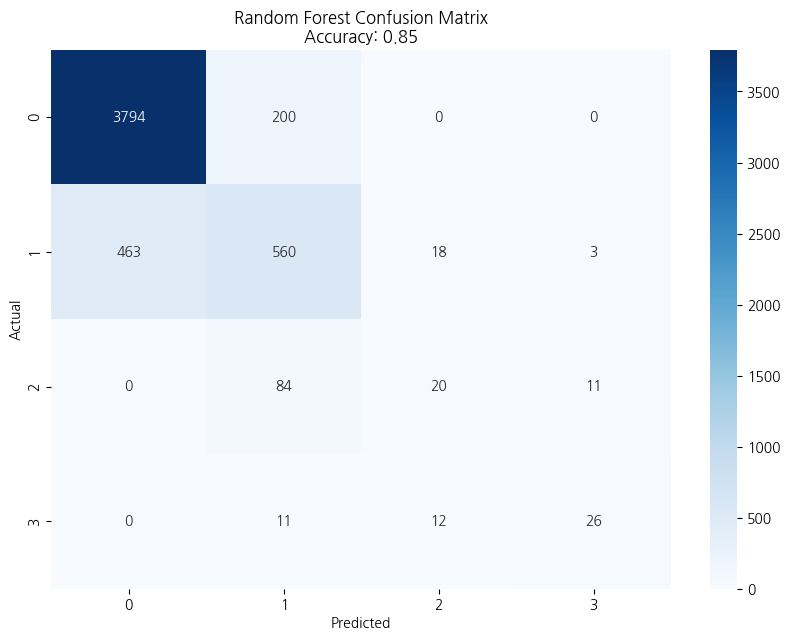

In [25]:
# Random Forest
rf_classifier = RandomForestClassifier(n_estimators=60, random_state=15)
evaluate_model(rf_classifier, 'Random Forest')

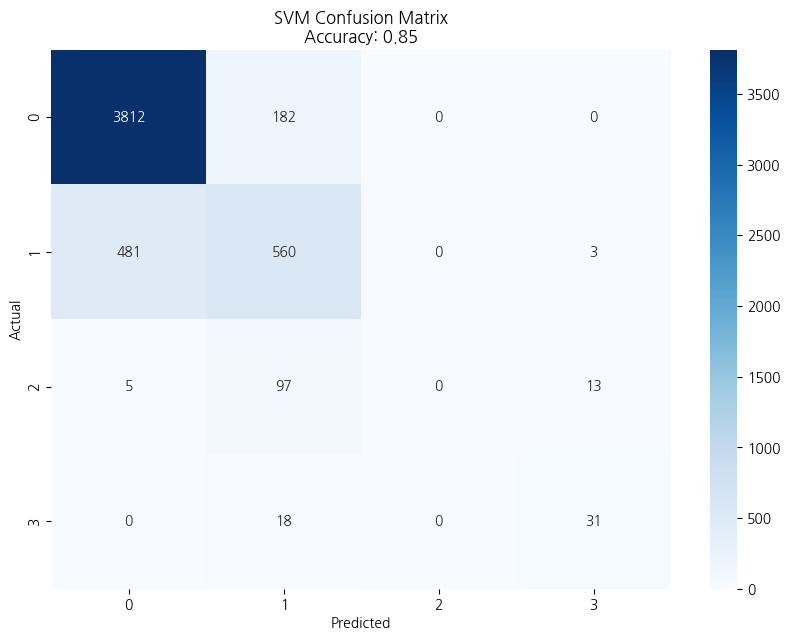

In [26]:
# SVM
svm_classifier = SVC(kernel='linear', random_state=15)
evaluate_model(svm_classifier, 'SVM')

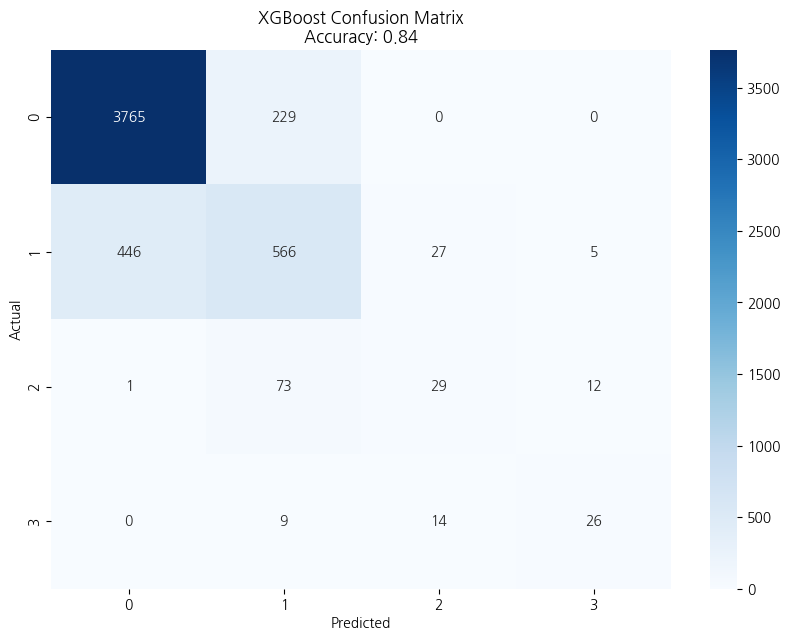

In [27]:
# XGBoost
xgb_classifier = XGBClassifier(eval_metric='logloss', random_state=15)
evaluate_model(xgb_classifier, 'XGBoost')

In [28]:
# 성능 데이터프레임 생성
performance_15 = pd.DataFrame(performance_list)
print(performance_15)
performance_15.to_csv('binning_15_hist.csv', index=False, encoding='utf-8-sig')

            Model Class  Accuracy  Precision    Recall  F1-Score  Support
0   Decision Tree     0  0.759516   0.872732  0.855033  0.863792   3994.0
1   Decision Tree     1  0.759516   0.428314  0.454981  0.441245   1044.0
2   Decision Tree     2  0.759516   0.283465  0.313043  0.297521    115.0
3   Decision Tree     3  0.759516   0.471698  0.510204  0.490196     49.0
4   Random Forest     0  0.845829   0.891238  0.949925  0.919646   3994.0
5   Random Forest     1  0.845829   0.654971  0.536398  0.589784   1044.0
6   Random Forest     2  0.845829   0.400000  0.173913  0.242424    115.0
7   Random Forest     3  0.845829   0.650000  0.530612  0.584270     49.0
8             SVM     0  0.846405   0.886924  0.954432  0.919440   3994.0
9             SVM     1  0.846405   0.653442  0.536398  0.589164   1044.0
10            SVM     2  0.846405   1.000000  0.000000  0.000000    115.0
11            SVM     3  0.846405   0.659574  0.632653  0.645833     49.0
12        XGBoost     0  0.843137   0.

### Binning / 10구간 Modeling

In [29]:
performance_list = []
num_classes = 4
# 조건과 조건에 따른 값을 지정
conditions = [
    (df['patientsCnt'] >= 1) & (df['patientsCnt'] < 8),
    (df['patientsCnt'] >= 8) & (df['patientsCnt'] < 16),
    (df['patientsCnt'] >= 16)
]

# 각 조건에 해당하는 값
values = [1, 2, 3]

df['binning_10'] = np.select(conditions, values, default=0)

In [30]:
# create_date에 대한 sorting 적용
df['create_date'] = pd.to_datetime(df['create_date'])
df.sort_values(by='create_date', inplace=True)
# 결측치 채우기
df = df.fillna(0)

features=['weekend_yn', 'min_ta', 'max_ta', 'mean_ta', 'gap_ta', 'min_tafeel', 'max_tafeel', 'mean_tafeel', 'gap_tafeel', 'min_hm', 'max_hm', 'mean_hm', 'gap_hm', 'min_wbtemp', 'max_wbtemp', 'mean_wbtemp', 'gap_wbtemp', 'min_ws', 'max_ws', 'mean_ws', 'tropical_3days',
       'heatwave_temp', 'heatalert_temp', 'ta_min_3days', 'ta_max_3days', 'gap_ta_minmax', 'popular_man', 'popular_woman', 'agriculture_man', 'agriculture_woman', 'ta_min_am', 'ta_max_am', 'ta_mean_am', 'ta_min_pm', 'ta_max_pm', 'ta_mean_pm', 'ta_min_six_am1',
       'ta_max_six_am1', 'ta_mean_six_am1', 'ta_min_six_am2', 'ta_max_six_am2', 'ta_mean_six_am2', 'ta_min_six_pm1', 'ta_max_six_pm1', 'ta_mean_six_pm1', 'ta_min_six_pm2', 'ta_max_six_pm2', 'ta_mean_six_pm2']
target='binning_10'
print(len(features))

48


In [31]:
# 기본 모델(RandomForest, XGBoost)
# 학습 데이터와 테스트 데이터로 분할
# 데이터 스케일링
X_train, X_test, y_train, y_test = train_test_split(df[features], df[target], test_size=0.2, random_state=15, shuffle=True)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


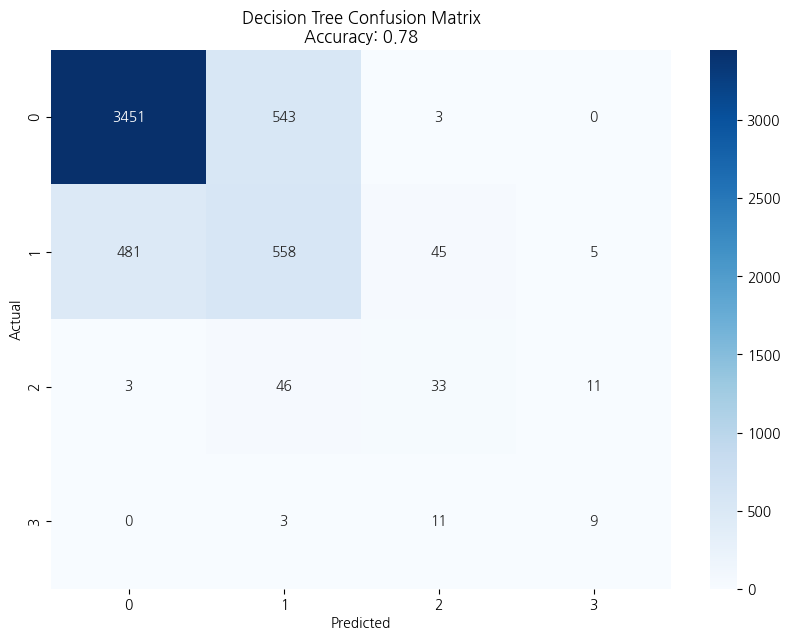

In [32]:
# Decision Tree
dt_classifier = DecisionTreeClassifier(random_state=15)
evaluate_model(dt_classifier, 'Decision Tree')

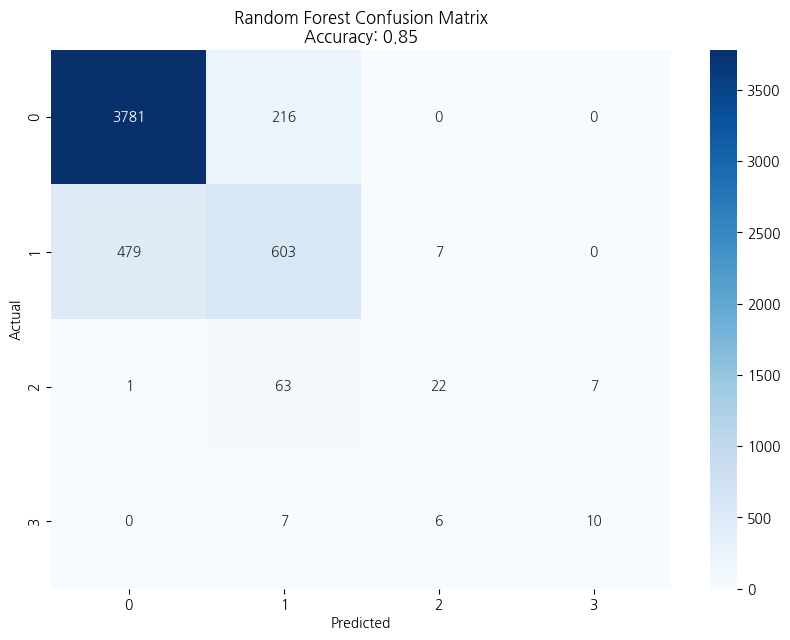

In [33]:
# Random Forest
rf_classifier = RandomForestClassifier(n_estimators=60, random_state=15)
evaluate_model(rf_classifier, 'Random Forest')

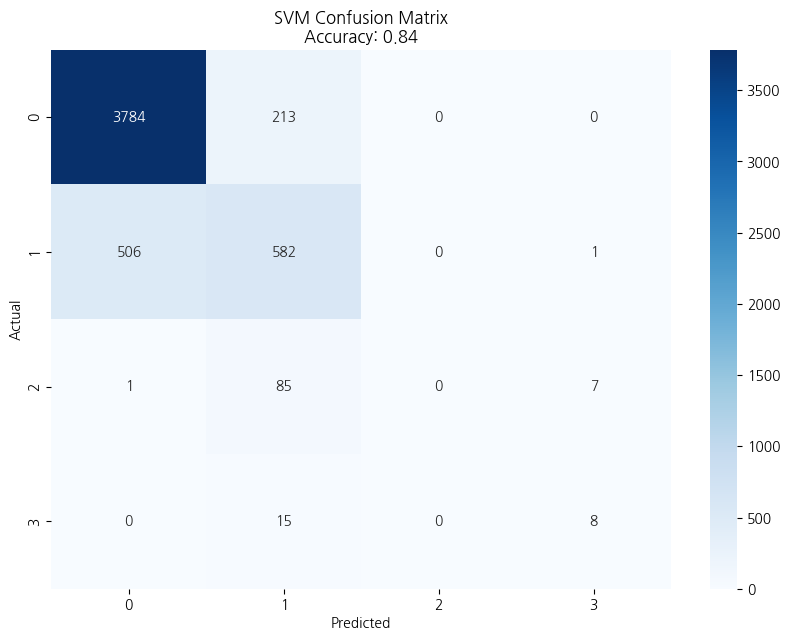

In [34]:
# SVM
svm_classifier = SVC(kernel='linear', random_state=15)
evaluate_model(svm_classifier, 'SVM')

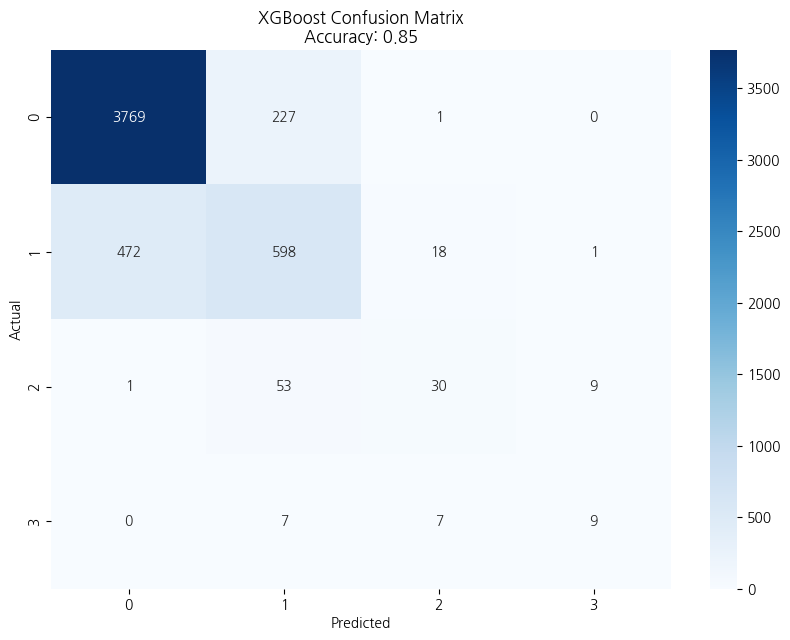

In [35]:
# XGBoost
xgb_classifier = XGBClassifier(eval_metric='logloss', random_state=15)
evaluate_model(xgb_classifier, 'XGBoost')

In [36]:
# 성능 데이터프레임 생성
performance_10 = pd.DataFrame(performance_list)
print(performance_10)
performance_10.to_csv('binning_10_hist.csv', index=False, encoding='utf-8-sig')

            Model Class  Accuracy  Precision    Recall  F1-Score  Support
0   Decision Tree     0  0.778739   0.877001  0.863398  0.870146   3997.0
1   Decision Tree     1  0.778739   0.485217  0.512397  0.498437   1089.0
2   Decision Tree     2  0.778739   0.358696  0.354839  0.356757     93.0
3   Decision Tree     3  0.778739   0.360000  0.391304  0.375000     23.0
4   Random Forest     0  0.848904   0.887350  0.945959  0.915718   3997.0
5   Random Forest     1  0.848904   0.678290  0.553719  0.609707   1089.0
6   Random Forest     2  0.848904   0.628571  0.236559  0.343750     93.0
7   Random Forest     3  0.848904   0.588235  0.434783  0.500000     23.0
8             SVM     0  0.840830   0.881846  0.946710  0.913127   3997.0
9             SVM     1  0.840830   0.650279  0.534435  0.586694   1089.0
10            SVM     2  0.840830   1.000000  0.000000  0.000000     93.0
11            SVM     3  0.840830   0.500000  0.347826  0.410256     23.0
12        XGBoost     0  0.846982   0.